In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import math

# Import from our sudoku.py module
sys.path.append('.')
from sudoku import (
    SudokuDataset, SudokuMDM, MDMTrainer, MDMSampler,
    MaskSchedule, check_sudoku_valid, evaluate_samples
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.1+cu128


In [4]:
# Load model
model_path = Path('./checkpoints/sudoku_mdm_best.pt')
model_config = {
    'vocab_size': 10,  # 0 (mask) + 1-9 (digits)
    'd_model': 384,
    'nhead': 12,
    'num_layers': 4,
    'dim_feedforward': 512,
    'dropout': 0.1,
    'max_seq_len': 81  # 9x9 Sudoku
}

# Create model
model = SudokuMDM(**model_config).to(device)
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])

/home/jaisharma/miniconda3/envs/sudoku/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


<All keys matched successfully>

In [5]:
def generate_conditional_entropy_data(
    model: SudokuMDM, puzzles: torch.Tensor, k=9, batch_size=256
):
    """
    Generate ground truth conditional entropy matrices for multiple puzzles (batched).
    
    For each position i, we compute H(j | i, c) = sum_xi P(xi | c) * H(j | xi, c)
    
    Args:
        model: Trained SudokuMDM
        puzzles: [num_puzzles, 81] tensor of input puzzles
        k: Number of top tokens to consider (max 9 for digits 1-9)
        batch_size: Number of (puzzle, position, token) tuples to process at once
    
    Returns:
        CE_matrices: [num_puzzles, 81, 81] tensor of conditional entropy values H(j | i)
    """
    # Ensure puzzles is on the correct device and has right shape
    if puzzles.dim() == 1:
        puzzles = puzzles.unsqueeze(0)
    
    puzzles = puzzles.to(device)
    num_puzzles = puzzles.size(0)

    # print(f"Generating conditional entropy data for {num_puzzles} puzzles (batched)...")
    # print(f"Using top-{k} tokens weighted by their probabilities")
    
    with torch.no_grad():
        # Initial forward pass to get P(j | c) for all puzzles
        initial_logits = model(puzzles)  # Shape: (num_puzzles, 81, 10)
        initial_probs = F.softmax(initial_logits, dim=-1)  # Shape: (num_puzzles, 81, 10)
        
        CE_matrices = torch.zeros((num_puzzles, 81, 81)).to(device)
        
        # Build list of all (puzzle_idx, position, token, weight) tuples to process
        all_queries = []  # List of (puzzle_idx, pos_i, token, weight)
        
        for p_idx in range(num_puzzles):
            # Find masked positions for this puzzle
            masked_positions = (puzzles[p_idx] == 0).nonzero(as_tuple=True)[0].tolist()
            
            for i in masked_positions:
                # Get top-k tokens and their probabilities for position i
                topk_probs, topk_tokens = torch.topk(initial_probs[p_idx, i, 1:], k)
                topk_tokens += 1  # Adjust indices since we excluded token 0
                
                # Normalize probabilities
                weights = topk_probs / topk_probs.sum()
                
                for idx, token in enumerate(topk_tokens):
                    all_queries.append((p_idx, i, token.item(), weights[idx].item()))
        
        # print(f"Total queries to process: {len(all_queries)}")
        
        # Process in batches
        num_batches = (len(all_queries) + batch_size - 1) // batch_size
        
        for batch_idx in range(num_batches):
            start = batch_idx * batch_size
            end = min(start + batch_size, len(all_queries))
            batch_queries = all_queries[start:end]
            
            # Create batched input - each query modifies its corresponding puzzle
            batch_puzzles = torch.zeros((len(batch_queries), 81), dtype=torch.long, device=device)
            
            for b, (p_idx, pos_i, token, weight) in enumerate(batch_queries):
                batch_puzzles[b] = puzzles[p_idx].clone()
                batch_puzzles[b, pos_i] = token
            
            # Batched forward pass
            logits = model(batch_puzzles)  # Shape: (B, 81, 10)
            probs = F.softmax(logits, dim=-1)  # Shape: (B, 81, 10)
            
            # H(j | x_i) for all j, for each sample in batch
            H_j_given_xi = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)  # Shape: (B, 81)
            
            # Accumulate weighted contributions to the correct puzzle's CE matrix
            for b, (p_idx, pos_i, token, weight) in enumerate(batch_queries):
                CE_matrices[p_idx, pos_i] += weight * H_j_given_xi[b]
            
            if (batch_idx + 1) % 20 == 0 or batch_idx == num_batches - 1:
                #print(f"  Processed batch {batch_idx + 1}/{num_batches}")
                ...
        # CE should be non-negative
        CE_matrices = torch.clamp(CE_matrices, min=0)
        
    return CE_matrices

In [6]:
def generate_sparse_ce_data(
    model: SudokuMDM, 
    puzzles: torch.Tensor, 
    num_pairs: int = 64, 
    k=9
):
    """
    Randomly samples pairs (i, j) and computes H(j | i) only for those pairs.
    """
    B, L = puzzles.shape
    device = puzzles.device
    
    with torch.no_grad():
        base_logits = model(puzzles)
        base_probs = F.softmax(base_logits, dim=-1)
        
        # 1. Select Random Pairs
        batch_queries = []
        
        for b in range(B):
            masked_indices = (puzzles[b] == 0).nonzero(as_tuple=True)[0]
            # Need at least 2 masks to form a pair (i, j) where i != j
            if len(masked_indices) < 2: 
                continue
                
            # Sample random indices
            i_choices = masked_indices[torch.randint(0, len(masked_indices), (num_pairs,))]
            j_choices = masked_indices[torch.randint(0, len(masked_indices), (num_pairs,))]
            
            for idx in range(num_pairs):
                i, j = i_choices[idx].item(), j_choices[idx].item()
                if i == j: continue 
                batch_queries.append((b, i, j))

        # --- FIX 1: Handle Empty Batch ---
        if not batch_queries:
            # Return empty tensors with correct 2D shape [0, 3]
            return (torch.zeros((0, 3), dtype=torch.long, device=device), 
                    torch.zeros(0, device=device))
        
        # 2. Process Queries (Sparse)
        unique_sources = set((b, i) for b, i, j in batch_queries)
        
        # Pre-compute hypothesis states
        eval_batch_puzzles = []
        eval_meta = [] 
        
        for (b, i) in unique_sources:
            probs_i = base_probs[b, i, 1:] 
            top_p, top_idx = torch.topk(probs_i, k)
            top_idx = top_idx + 1 
            weights = top_p / top_p.sum()
            
            for k_idx in range(k):
                token = top_idx[k_idx].item()
                weight = weights[k_idx].item()
                
                p_new = puzzles[b].clone()
                p_new[i] = token
                eval_batch_puzzles.append(p_new)
                eval_meta.append((b, i, token, weight))
        
        # Run huge batch of hypothetical puzzles
        mini_bs = 256
        H_j_cache = {} 
        
        for start in range(0, len(eval_batch_puzzles), mini_bs):
            end = min(start + mini_bs, len(eval_batch_puzzles))
            p_batch = torch.stack(eval_batch_puzzles[start:end])
            
            logits = model(p_batch)
            probs = F.softmax(logits, dim=-1)
            # Calculate entropy H(j) for all j
            entropies = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1).cpu()
            
            for idx_in_batch in range(end - start):
                global_idx = start + idx_in_batch
                b, i, token, _ = eval_meta[global_idx]
                H_j_cache[(b, i, token)] = entropies[idx_in_batch]
        
        # Aggregate results
        targets = torch.zeros(len(batch_queries), device=device)
        indices = torch.tensor(batch_queries, device=device) # [N, 3]
        
        for idx, (b, i, j) in enumerate(batch_queries):
            probs_i = base_probs[b, i, 1:]
            top_p, top_idx = torch.topk(probs_i, k)
            weights = top_p / top_p.sum()
            top_idx = top_idx + 1
            
            h_val = 0
            for k_idx in range(k):
                token = top_idx[k_idx].item()
                weight = weights[k_idx].item()
                h_j_given_x = H_j_cache[(b, i, token)][j].item()
                h_val += weight * h_j_given_x
            
            targets[idx] = h_val
            
    return indices, targets

In [7]:
class CEPredictor(nn.Module):
    """
    Lightweight module to predict conditional entropy matrix H(j | i, c) given a puzzle c.
    
    Uses frozen embeddings from a pre-trained MDM model, then adds a small trainable head
    to predict pairwise conditional entropy.
    
    Architecture:
    1. Get contextualized embeddings from frozen MDM (no grad)
    2. Project to smaller dimension
    3. Bilinear pairwise prediction head
    
    Output: [batch_size, 81, 81] matrix where entry (i, j) = H(X_j | X_i, c)
    """
    def __init__(
        self,
        mdm_model: SudokuMDM,
        hidden_dim: int = 64,
        dropout: float = 0.1,
        freeze_mdm: bool = True
    ):
        super(CEPredictor, self).__init__()
        
        self.mdm = mdm_model
        self.mdm_dim = mdm_model.d_model  # e.g., 384
        self.hidden_dim = hidden_dim
        
        # Freeze MDM parameters
        if freeze_mdm:
            for param in self.mdm.parameters():
                param.requires_grad = False
        
        # Project MDM embeddings to smaller dimension
        self.proj = nn.Linear(self.mdm_dim, hidden_dim)
        
        # Separate projections for "source" (i) and "target" (j) roles
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)  # "if I reveal i..."
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)    # "...entropy of j"
        
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # Small MLP head for final prediction
        self.ce_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        # Only init the trainable layers (not MDM)
        for module in [self.proj, self.query_proj, self.key_proj, self.ce_head]:
            for p in module.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
    
    def get_mdm_embeddings(self, x: torch.Tensor) -> torch.Tensor:
        """
        Extract contextualized embeddings from the MDM.
        
        Args:
            x: [batch_size, 81] - puzzle tokens
            
        Returns:
            h: [batch_size, 81, mdm_dim] - contextualized representations
        """
        # Run through MDM's embedding + positional encoding + transformer
        # but stop before the output head
        with torch.no_grad():
            h = self.mdm.embedding(x)  # [B, 81, d_model]
            h = self.mdm.pos_encoder(h)  # Add positional encoding
            h = self.mdm.transformer(h)  # [B, 81, d_model]
        return h
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [batch_size, 81] - puzzle with token indices (0 = mask, 1-9 = digits)
            
        Returns:
            ce_matrix: [batch_size, 81, 81] - predicted H(j | i, c) for all pairs
        """
        # Get frozen MDM embeddings
        h = self.get_mdm_embeddings(x)  # [B, 81, mdm_dim]
        h.requires_grad = True
        # Project to smaller dimension
        h = self.proj(h)  # [B, 81, hidden_dim]
        
        # Compute pairwise CE predictions
        # Query: "if I reveal position i..."
        # Key: "...what is the entropy of position j?"
        queries = self.query_proj(h)  # [B, 81, hidden_dim]
        keys = self.key_proj(h)       # [B, 81, hidden_dim]
        
        # Pairwise interaction: element-wise product
        # [B, 81, 1, hidden_dim] * [B, 1, 81, hidden_dim] -> [B, 81, 81, hidden_dim]
        interaction = queries.unsqueeze(2) * keys.unsqueeze(1)
        interaction = self.layer_norm(interaction)
        
        # Predict CE from interaction features
        ce_matrix = self.ce_head(interaction).squeeze(-1)  # [B, 81, 81]
        
        # CE must be non-negative
        ce_matrix = F.softplus(ce_matrix)
        
        return ce_matrix


class CEPredictorTrainer:
    """
    Trainer for the CE predictor with on-the-fly CE generation.
    
    Instead of using pre-computed CE matrices, this trainer:
    1. Takes solutions from a DataLoader
    2. Applies random masking to create puzzles
    3. Generates ground truth CE matrices on-the-fly
    4. Trains the predictor on these
    """
    
    def __init__(
        self,
        predictor: CEPredictor,
        dataset: SudokuDataset,
        mask_schedule: MaskSchedule,
        lr: float = 1e-3,
        weight_decay: float = 0.01,
        batch_size: int = 32,
        ce_batch_size: int = 256,
        k: int = 9
    ):
        self.predictor = predictor
        self.dataset = dataset
        self.mask_schedule = mask_schedule
        self.batch_size = batch_size
        self.ce_batch_size = ce_batch_size  # batch size for CE generation
        self.k = k  # top-k tokens for CE computation
        
        # Create DataLoader
        self.dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True
        )
        self.dataloader_iter = iter(self.dataloader)
        
        # Only optimize the trainable parameters (not frozen MDM)
        trainable_params = [p for p in predictor.parameters() if p.requires_grad]
        print(f"Trainable parameters: {sum(p.numel() for p in trainable_params):,}")
        
        self.optimizer = torch.optim.AdamW(
            trainable_params,
            lr=lr,
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=1000
        )
        self.train_losses = []
    
    def _get_batch(self):
        """Get next batch from dataloader, reset if exhausted."""
        try:
            batch = next(self.dataloader_iter)
        except StopIteration:
            self.dataloader_iter = iter(self.dataloader)
            batch = next(self.dataloader_iter)
        return batch
    
    def _apply_random_masking(self, solutions: torch.Tensor) -> torch.Tensor:
        """
        Apply random masking to solutions to create puzzles.
        
        Args:
            solutions: [batch_size, 81] - complete Sudoku solutions
            
        Returns:
            puzzles: [batch_size, 81] - masked puzzles
        """
        puzzles = solutions.clone()
        t = np.random.randint(1, self.mask_schedule.total_steps + 1)  # At least 1 mask
        mask_ratio = self.mask_schedule.get_mask_ratio(t)
        puzzles, _ = self.mask_schedule.apply_mask(puzzles, mask_ratio)
        return puzzles
    
    def train_step(self) -> float:
        self.predictor.train()
        self.optimizer.zero_grad()
        
        _, solutions = self._get_batch()
        solutions = solutions.to(next(self.predictor.parameters()).device)
        puzzles = self._apply_random_masking(solutions)
        
        # 1. Generate Sparse Ground Truth
        indices, targets = generate_sparse_ce_data(
            self.predictor.mdm, puzzles, num_pairs=64, k=self.k
        )
        
        # --- FIX 2: Skip if no pairs were found ---
        if indices.size(0) == 0:
            # No masked pairs available to learn from in this batch
            return 0.0

        # 2. Forward Pass 
        pred_ce_matrix = self.predictor(puzzles) # [B, 81, 81]
        
        # 3. Gather predictions 
        batch_idx = indices[:, 0]
        i_idx = indices[:, 1]
        j_idx = indices[:, 2]
        
        pred_values = pred_ce_matrix[batch_idx, i_idx, j_idx]
        
        # 4. Loss
        loss = F.smooth_l1_loss(pred_values, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.predictor.parameters(), 1.0)
        self.optimizer.step()
        self.scheduler.step()
        
        return loss.item()
    
    def train_epoch(self, steps_per_epoch: int = None) -> float:
        """
        Train for one epoch (or specified number of steps).
        
        Args:
            steps_per_epoch: Number of steps. If None, use len(dataloader).
            
        Returns:
            Average loss for the epoch
        """
        if steps_per_epoch is None:
            steps_per_epoch = len(self.dataloader)
        
        epoch_losses = []
        for step in range(steps_per_epoch):
            loss = self.train_step()
            epoch_losses.append(loss)
            
            if (step + 1) % 10 == 0:
                avg_loss = sum(epoch_losses[-10:]) / min(10, len(epoch_losses))
                print(f"  Step {step + 1}/{steps_per_epoch}, Loss: {avg_loss:.6f}")
        
        return sum(epoch_losses) / len(epoch_losses)
    
    @torch.no_grad()
    def evaluate(self, num_samples: int = 100) -> dict:
        """Evaluate predictor on random validation samples."""
        self.predictor.eval()
        
        # Generate some validation puzzles
        """TypeError: expected Tensor as element 0 in argument 0, but got tuple"""
        solutions = torch.stack([self.dataset[i][1] for i in range(num_samples)])
        solutions = solutions.to(next(self.predictor.parameters()).device)
        puzzles = self._apply_random_masking(solutions)
        
        # Generate ground truth CE
        target_ce = generate_conditional_entropy_data(
            self.predictor.mdm,
            puzzles,
            k=self.k,
            batch_size=self.ce_batch_size
        )
        
        # Predict
        pred_ce = self.predictor(puzzles)
        
        mask = (puzzles == 0)
        row_mask = mask.unsqueeze(2).expand_as(pred_ce)
        
        if row_mask.any():
            mse = F.mse_loss(pred_ce[row_mask], target_ce[row_mask]).item()
            mae = F.l1_loss(pred_ce[row_mask], target_ce[row_mask]).item()
        else:
            mse, mae = 0.0, 0.0
        
        return {'mse': mse, 'mae': mae}


# Create predictor that uses the frozen MDM embeddings
ce_predictor = CEPredictor(
    mdm_model=model,
    hidden_dim=64,
    dropout=0.1,
    freeze_mdm=True
).to(device)

# Count only trainable parameters
trainable_params = sum(p.numel() for p in ce_predictor.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in ce_predictor.parameters())
print(f"CE Predictor:")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Total parameters (including frozen MDM): {total_params:,}")
print(f"  MDM parameters (frozen): {total_params - trainable_params:,}")

CE Predictor:
  Trainable parameters: 37,313
  Total parameters (including frozen MDM): 4,195,659
  MDM parameters (frozen): 4,158,346


In [8]:
# train!
dataset = SudokuDataset(data_path='./data/sudoku.csv', num_samples=100000)
trainer = CEPredictorTrainer(
    predictor=ce_predictor,
    dataset=dataset,
    mask_schedule=MaskSchedule(schedule_type='linear', total_steps=40),
    lr=1e-4,
    weight_decay=0.01,
    batch_size=32,
    ce_batch_size=256,
    k=9
)

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    avg_loss = trainer.train_epoch(steps_per_epoch=100)
    print(f"  Average Loss: {avg_loss:.6f}")
    
    eval_metrics = trainer.evaluate(num_samples=100)
    print(f"  Eval MSE: {eval_metrics['mse']:.6f}, MAE: {eval_metrics['mae']:.6f}")

# Save trained predictor
torch.save(
    ce_predictor.state_dict(),
    './checkpoints/ce_predictor_sudoku_mdm.pt'
)


Loading Sudoku from CSV: ./data/sudoku.csv (start=0, n=100000)
✓ Loaded 100000 puzzles from CSV: ./data/sudoku.csv
Trainable parameters: 37,313
Epoch 1/10
  Step 10/100, Loss: 0.088537
  Step 20/100, Loss: 0.244005
  Step 30/100, Loss: 0.444916
  Step 40/100, Loss: 0.151804
  Step 50/100, Loss: 0.103896
  Step 60/100, Loss: 0.065555
  Step 70/100, Loss: 0.052519
  Step 80/100, Loss: 0.043232
  Step 90/100, Loss: 0.042124
  Step 100/100, Loss: 0.018622
  Average Loss: 0.125521
  Eval MSE: 3.085502, MAE: 1.561332
Epoch 2/10
  Step 10/100, Loss: 0.031576
  Step 20/100, Loss: 0.031052
  Step 30/100, Loss: 0.016318
  Step 40/100, Loss: 0.020381
  Step 50/100, Loss: 0.026625
  Step 60/100, Loss: 0.028084
  Step 70/100, Loss: 0.014819
  Step 80/100, Loss: 0.014379
  Step 90/100, Loss: 0.017538
  Step 100/100, Loss: 0.024363
  Average Loss: 0.022514
  Eval MSE: 2.752532, MAE: 1.404569
Epoch 3/10
  Step 10/100, Loss: 0.024424
  Step 20/100, Loss: 0.014833
  Step 30/100, Loss: 0.013113
  Step 40

KeyboardInterrupt: 

In [35]:
import torch
import torch.nn.functional as F

class ParallelSudokuSolver:
    def __init__(self, mdm_model, ce_predictor, device='cuda'):
        self.mdm = mdm_model
        self.ce_predictor = ce_predictor
        self.device = device
        self.mdm.eval()
        self.ce_predictor.eval()

    @torch.no_grad()
    def get_mi_matrix(self, puzzle, temperature=1.0):
        # Apply Temperature to base logits
        logits = self.mdm(puzzle)
        probs = F.softmax(logits[:, :, 1:] / temperature, dim=-1) # slice 1-9
        
        # H(j) based on temperature distribution
        H_j = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
        
        # Predict Conditional Entropy 
        # (Technically predictor was trained on temp=1, but it generalizes okay)
        H_j_given_i = self.ce_predictor(puzzle)
        
        # Adjust predictor scale if needed, but usually raw subtraction works
        # MI = H(j) - H(j|i)
        MI_matrix = H_j.unsqueeze(1) - H_j_given_i
        MI_matrix = (MI_matrix + MI_matrix.transpose(1, 2)) / 2.0
        return H_j, torch.clamp(MI_matrix, min=0)

    def solve_step(self, puzzle, k=5, temperature=1.0, redundancy_penalty=1.0, noise_scale=0.1):
        """
        Selects k tokens to unmask in parallel.
        
        Score(i) = Entropy(i) + lambda * max(MI(i, j) for j in selected)
        We want Minimum Entropy (High Confidence) and Minimum MI (Independence).
        """
        B = puzzle.size(0)
        
        # Get Entropies and MI
        H_j, MI = self.get_mi_matrix(puzzle, temperature=temperature)
        
        # Identify Masked Indices
        # We process batch items individually for the greedy loop 
        # (Vectorizing the greedy loop is hard)
        
        new_puzzles = puzzle.clone()
        
        for b in range(B):
            masked_indices = (puzzle[b] == 0).nonzero(as_tuple=True)[0]
            if len(masked_indices) == 0:
                continue
                
            # Candidates: masked positions
            candidates = masked_indices.tolist()
            selected = []
            
            # 1. Pick the single most confident token (Lowest Entropy)
            # Filter H_j to only masked positions
            candidate_entropies = H_j[b, candidates]
            best_first_idx = torch.argmin(candidate_entropies).item()
            first_selection = candidates[best_first_idx]
            
            selected.append(first_selection)
            candidates.pop(best_first_idx)
            
            # 2. Greedily add k-1 more tokens
            while len(selected) < k and len(candidates) > 0:
                best_score = float('inf')
                best_cand = -1
                best_cand_idx = -1
                
                # Evaluate all candidates against currently selected set
                for idx, cand in enumerate(candidates):
                    # Base score: How confused is the model about this token?
                    entropy_score = H_j[b, cand].item()
                    
                    # Penalty: How correlated is this token to the ones we already picked?
                    # We take the MAX correlation (if it conflicts with ANY selected, it's bad)
                    mi_penalty = 0
                    if selected:
                        mi_scores = MI[b, cand, selected]
                        mi_penalty = torch.max(mi_scores).item()
                    
                    noise = torch.randn(1).item() * noise_scale
                    
                    # MMR Score (Lower is better)
                    total_score = entropy_score + (redundancy_penalty * mi_penalty) + noise
                    
                    if total_score < best_score:
                        best_score = total_score
                        best_cand = cand
                        best_cand_idx = idx
                
                if best_cand != -1:
                    selected.append(best_cand)
                    candidates.pop(best_cand_idx)
            
            # 3. Unmask the selected tokens using the Base Model's predictions
            # We use the argmax of the base logits
            logits = self.mdm(puzzle[b:b+1])
            probs = F.softmax(logits[:, :, 1:] / temperature, dim=-1)
            
            for pos in selected:
                # Sample or Argmax? For solving, usually Argmax or Temperature sampling
                # Here we do greedy argmax for stability
                predicted_token = torch.argmax(probs[0, pos, 1:]) + 1 # +1 for 1-9
                new_puzzles[b, pos] = predicted_token
                
        return new_puzzles

    def solve(self, puzzle, steps=10, k_per_step=5, temperature=1.2, noise_scale=0.5):
        """Full iterative solver"""
        current = puzzle.clone()
        trajectory = [current.clone()]
        
        for t in range(steps):
            if (current == 0).sum() == 0:
                break
                
            current = self.solve_step(current, k=k_per_step, temperature=temperature, noise_scale=noise_scale)
            trajectory.append(current.clone())
            
        return current, trajectory

In [42]:
# --- Usage Example ---

solver = ParallelSudokuSolver(model, ce_predictor, device=device)

# Take a validation puzzle and mask it completely
_, solution = dataset[0]
empty_puzzle = torch.zeros((1, 81), dtype=torch.long, device=device)

# Solve in ~10 steps (unmasking 8 tokens at a time)
solved_puzzle, traj = solver.solve(empty_puzzle, steps=15, k_per_step=8)

print("Check Valid:", check_sudoku_valid(solved_puzzle[0]))

Check Valid: True


In [40]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class SudokuEvaluator:
    def __init__(self, mdm_model, ce_predictor, dataset, device='cuda'):
        self.mdm = mdm_model
        self.ce_predictor = ce_predictor
        self.dataset = dataset
        self.device = device
        self.solver = ParallelSudokuSolver(mdm_model, ce_predictor, device)
        
    def run_baseline_confidence(self, puzzle, k=5, temperature=1.0):
        current = puzzle.clone()
        while (current == 0).sum() > 0:
            # 1. Get Logits & Apply Temperature
            logits = self.mdm(current)
            # Focus only on digits 1-9 (index 0 is mask)
            valid_logits = logits[:, :, 1:] / temperature
            probs = F.softmax(valid_logits, dim=-1)
            
            # Calculate Entropy for sorting (Higher temp = Higher Entropy)
            H_j = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            
            mask_indices = (current == 0)
            H_j[~mask_indices] = float('inf')
            
            # 2. Select k positions
            num_masked = mask_indices.sum().item()
            actual_k = min(k, num_masked)
            if actual_k == 0: break
                
            _, candidates = torch.topk(H_j, k=actual_k, largest=False)
            
            # 3. SAMPLE values (Don't Argmax)
            for pos in candidates[0]:
                # Sample from the distribution
                token_dist = torch.distributions.Categorical(probs[0, pos])
                pred_token = token_dist.sample() + 1 # +1 because we sliced [1:]
                current[0, pos] = pred_token
                
        return current

    def run_baseline_random(self, puzzle, k=5):
        """Baseline: Pick k random tokens"""
        current = puzzle.clone()
        while (current == 0).sum() > 0:
            mask_indices = (current == 0).nonzero(as_tuple=True)[1]
            if len(mask_indices) == 0: break
            
            actual_k = min(k, len(mask_indices))
            perm = torch.randperm(len(mask_indices))
            selected = mask_indices[perm[:actual_k]]
            
            logits = self.mdm(current)
            probs = F.softmax(logits, dim=-1)
            
            for pos in selected:
                pred_token = torch.argmax(probs[0, pos, 1:]) + 1
                current[0, pos] = pred_token
                
        return current

    def evaluate_all(self, num_puzzles=50, k_values=[1, 4, 8, 16, 32]):
        """
        Runs the comparison across different 'Step Sizes' (k).
        """
        results = {
            'k': k_values,
            'random': [],
            'confidence': [],
            'mi_guided': []
        }
        
        # Prepare Data
        # We start with empty puzzles (or partially masked)
        # Let's use completely empty puzzles to really stress test generation
        # Or masked versions from dataset. Let's use 100% mask for pure generation test.
        # Actually, solving 100% empty Sudoku is hard. Let's use the dataset's masks.
        
        test_puzzles = []
        solutions = []
        for i in range(num_puzzles):
            p, s = self.dataset[i] # p is masked, s is solution
            test_puzzles.append(p.unsqueeze(0).to(self.device))
            solutions.append(s.unsqueeze(0).to(self.device))

        print(f"Evaluating on {num_puzzles} puzzles...")
        
        for k in k_values:
            print(f"Testing Step Size k={k}...")
            
            scores = {'random': 0, 'confidence': 0, 'mi_guided': 0}
            
            for i in tqdm(range(num_puzzles)):
                p_init = test_puzzles[i]
                sol = solutions[i]
                
                # 1. Random
                res_rand = self.run_baseline_random(p_init, k=k)
                if check_sudoku_valid(res_rand[0]) and torch.equal(res_rand, sol):
                    scores['random'] += 1
                
                # 2. Confidence
                res_conf = self.run_baseline_confidence(p_init, k=k)
                if check_sudoku_valid(res_conf[0]) and torch.equal(res_conf, sol):
                    scores['confidence'] += 1
                    
                # 3. MI Guided (Your Method)
                # Note: Solve is iterative internally
                # We need to adapt the solver to take fixed k or use the adaptive one
                # Let's force fixed k for fair comparison
                res_mi, _ = self.solver.solve(p_init, steps=100, k_per_step=k)
                if check_sudoku_valid(res_mi[0]) and torch.equal(res_mi, sol):
                    scores['mi_guided'] += 1
            
            # Calculate percentages
            results['random'].append(scores['random'] / num_puzzles * 100)
            results['confidence'].append(scores['confidence'] / num_puzzles * 100)
            results['mi_guided'].append(scores['mi_guided'] / num_puzzles * 100)
            
        return results

    def plot_results(self, results):
        plt.figure(figsize=(10, 6))
        
        if 'random' in results and len(results['random']) > 0:
            plt.plot(results['k'], results['random'], 'o--', label='Random (Baseline)', color='gray')
        
        if 'confidence' in results:
            plt.plot(results['k'], results['confidence'], 's-', label='Confidence', color='blue')
            
        if 'mi_guided' in results:
            plt.plot(results['k'], results['mi_guided'], '^-', label='MI-Guided (Yours)', color='green', linewidth=2)
        
        plt.xlabel('Parallelism Factor (k)')
        plt.ylabel('Success Rate (%)')
        plt.title('Sudoku Generation Robustness')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(-5, 105)
        plt.show()

Evaluating on 50 puzzles...
Testing Step Size k=1...


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


Testing Step Size k=4...


100%|██████████| 50/50 [00:06<00:00,  7.77it/s]


Testing Step Size k=8...


100%|██████████| 50/50 [00:05<00:00,  9.70it/s]


Testing Step Size k=12...


100%|██████████| 50/50 [00:04<00:00, 10.65it/s]


Testing Step Size k=16...


100%|██████████| 50/50 [00:04<00:00, 11.10it/s]


Testing Step Size k=20...


100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


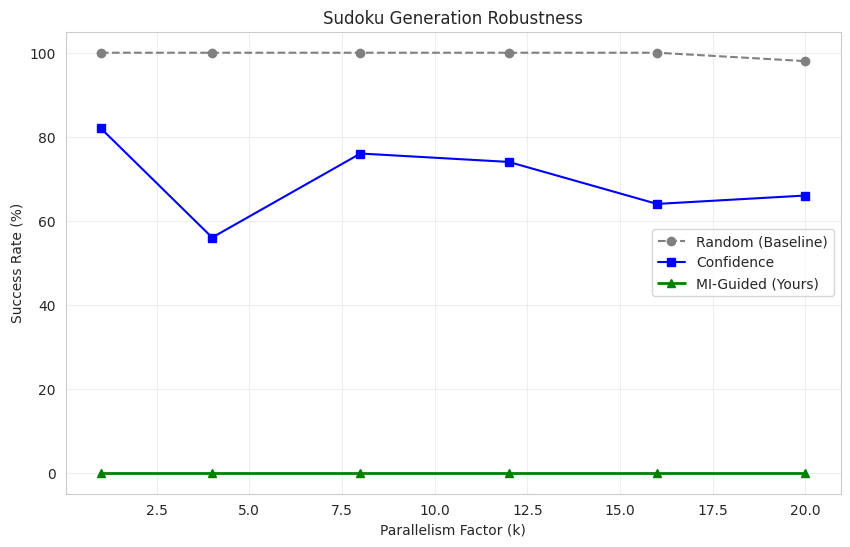

In [41]:
# --- Run Evaluation ---
evaluator = SudokuEvaluator(model, ce_predictor, dataset, device=device)

# We test k=[1, 4, 8, 12, 16, 20]
# k=1 is "Serial" (everyone should do well)
# k=20 is "Aggressive" (hard)
results = evaluator.evaluate_all(num_puzzles=50, k_values=[1, 4, 8, 12, 16, 20])
evaluator.plot_results(results)

STRESS TEST: Generating from EMPTY board (High Uncertainty)...
Testing K=16...
  K=16 | Conf: 100.0% | MI: 100.0%
Testing K=24...
  K=24 | Conf: 100.0% | MI: 100.0%
Testing K=32...
  K=32 | Conf: 100.0% | MI: 100.0%


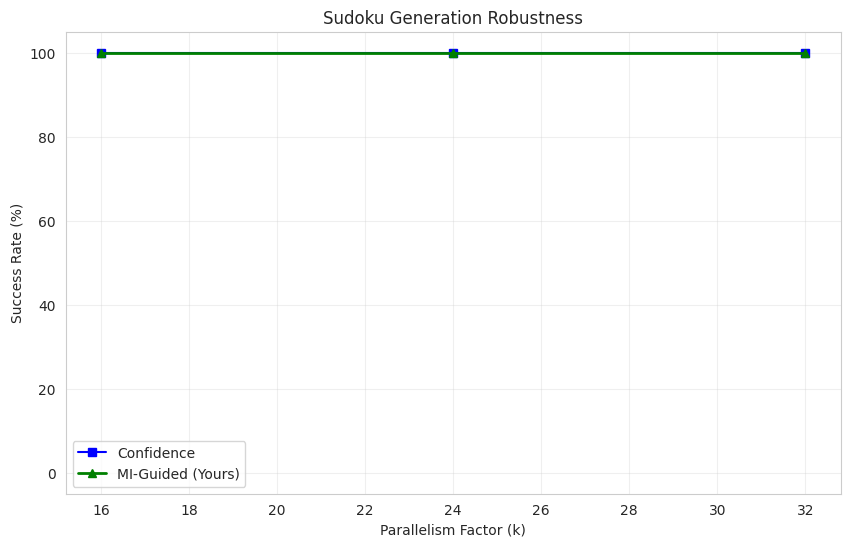

In [29]:
def stress_test_empty_generation(evaluator, num_samples=50, k_values=[8, 16, 24, 32]):
    """
    Stress test: Can you generate a valid Sudoku from a completely blank slate?
    """
    results = {'k': k_values, 'confidence': [], 'mi_guided': []}
    
    # Create empty boards [B, 81]
    # Note: A truly empty board is all zeros.
    empty_batch = torch.zeros((num_samples, 81), dtype=torch.long, device=evaluator.device)
    
    print(f"STRESS TEST: Generating from EMPTY board (High Uncertainty)...")
    
    for k in k_values:
        print(f"Testing K={k}...")
        
        # 1. Baseline: Confidence
        # We need to re-clone empty batch every time
        batch_conf = empty_batch.clone()
        success_conf = 0
        
        # Run solver logic manually or loop over batch
        for i in range(num_samples):
            # We treat each empty board as a fresh start
            res = evaluator.run_baseline_confidence(batch_conf[i:i+1], k=k)
            if check_sudoku_valid(res[0]):
                success_conf += 1
                
        # 2. MI Guided
        success_mi = 0
        for i in range(num_samples):
             # For empty board, we might need a distinct redundancy_penalty
             # penalty=2.0 is often good for high-ambiguity starts
            res, _ = evaluator.solver.solve(batch_conf[i:i+1], steps=100, k_per_step=k)
            if check_sudoku_valid(res[0]):
                success_mi += 1
        
        results['confidence'].append(success_conf / num_samples * 100)
        results['mi_guided'].append(success_mi / num_samples * 100)
        
        print(f"  K={k} | Conf: {results['confidence'][-1]}% | MI: {results['mi_guided'][-1]}%")
        
    return results

# Run the stress test
stress_results = stress_test_empty_generation(evaluator, num_samples=50, k_values=[16, 24, 32])
evaluator.plot_results(stress_results)

In [38]:
def check_diversity(evaluator, num_samples=20, k=16):
    print(f"Generating {num_samples} puzzles from EMPTY board (K={k})...")
    
    # 1. Confidence Baseline
    conf_puzzles = []
    for _ in range(num_samples):
        # Start clean each time
        empty = torch.zeros((1, 81), dtype=torch.long, device=evaluator.device)
        res = evaluator.run_baseline_confidence(empty, k=k)
        if check_sudoku_valid(res[0]):
            conf_puzzles.append(tuple(res[0].tolist()))
    
    # 2. MI Guided
    mi_puzzles = []
    for _ in range(num_samples):
        empty = torch.zeros((1, 81), dtype=torch.long, device=evaluator.device)
        # Use a slightly higher penalty to force exploration
        res, _ = evaluator.solver.solve(empty, steps=50, k_per_step=k)
        if check_sudoku_valid(res[0]):
            mi_puzzles.append(tuple(res[0].tolist()))
            
    n_unique_conf = len(set(conf_puzzles))
    n_unique_mi = len(set(mi_puzzles))
    
    print(f"\nRESULTS (Valid Solutions generated out of {num_samples}):")
    print(f"Confidence Baseline Unique Puzzles: {n_unique_conf}")
    print(f"MI-Guided Unique Puzzles:         {n_unique_mi}")
    
    if n_unique_conf == 1:
        print(">> DIAGNOSIS: MODE COLLAPSE in Baseline.")
        print("   The model just memorized one puzzle. Parallelization is 'easy' because it's just filling in a known template.")

In [31]:
check_diversity(evaluator)

Generating 20 puzzles from EMPTY board (K=16)...

RESULTS (Valid Solutions generated out of 20):
Confidence Baseline Unique Puzzles: 20
MI-Guided Unique Puzzles:         20


In [43]:
# 1. Update the Solver class with the 'noise_scale' change above.
# (Make sure to pass 'noise_scale' in the solve method too)

# 2. Run the Comparison
def find_breaking_point(evaluator, num_samples=50):
    # We test very aggressive step sizes
    k_values = [20, 30, 40, 50] 
    
    print(f"STRESS TEST: Searching for the Baseline's Breaking Point...")
    print(f"Conditions: Empty Board, Temperature=1.2 (for diversity)")
    
    for k in k_values:
        print(f"\n--- Testing Step Size K={k} ---")
        
        # 1. Baseline
        valid_conf = 0
        unique_conf = set()
        for _ in range(num_samples):
            empty = torch.zeros((1, 81), dtype=torch.long, device=evaluator.device)
            # Baseline is usually fast, so we can loop
            res = evaluator.run_baseline_confidence(empty, k=k, temperature=1.2)
            if check_sudoku_valid(res[0]):
                valid_conf += 1
                unique_conf.add(tuple(res[0].tolist()))
                
        # 2. MI-Guided (With Noise!)
        valid_mi = 0
        unique_mi = set()
        for _ in range(num_samples):
            empty = torch.zeros((1, 81), dtype=torch.long, device=evaluator.device)
            # noise_scale=0.5 ensures we pick different paths
            res, _ = evaluator.solver.solve(empty, steps=100, k_per_step=k, temperature=1.2, noise_scale=0.5) 
            if check_sudoku_valid(res[0]):
                valid_mi += 1
                unique_mi.add(tuple(res[0].tolist()))
        
        print(f"Baseline: {valid_conf}/{num_samples} Valid ({len(unique_conf)} unique)")
        print(f"MI-Guided: {valid_mi}/{num_samples} Valid ({len(unique_mi)} unique)")

        # Early exit if we found the winner
        if valid_conf < valid_mi and (valid_mi - valid_conf) > 5:
            print(f"\n>>> BREAKING POINT FOUND at K={k}!")
            print("The Baseline failed to handle dependencies, while MI persisted.")
            break

find_breaking_point(evaluator)

STRESS TEST: Searching for the Baseline's Breaking Point...
Conditions: Empty Board, Temperature=1.2 (for diversity)

--- Testing Step Size K=20 ---
Baseline: 50/50 Valid (50 unique)
MI-Guided: 50/50 Valid (50 unique)

--- Testing Step Size K=30 ---
Baseline: 50/50 Valid (50 unique)
MI-Guided: 50/50 Valid (50 unique)

--- Testing Step Size K=40 ---
Baseline: 50/50 Valid (50 unique)
MI-Guided: 50/50 Valid (50 unique)

--- Testing Step Size K=50 ---
Baseline: 50/50 Valid (50 unique)
MI-Guided: 50/50 Valid (50 unique)


In [44]:
# 1. Check if the validator is fake
dummy_zeros = torch.zeros(81, dtype=torch.long)
dummy_random = torch.randint(1, 10, (81,))
print(f"Validator Check (Zeros): {check_sudoku_valid(dummy_zeros)}")   # MUST be False
print(f"Validator Check (Random): {check_sudoku_valid(dummy_random)}") # MUST be False

# 2. Check how "Confident" the model is (Logit Magnitude)
empty = torch.zeros((1, 81), dtype=torch.long, device=device)
logits = model(empty)
print(f"Max Logit Value: {logits.max().item():.4f}")
print(f"Min Logit Value: {logits.min().item():.4f}")
# If Max > 20, Temp=1.2 does nothing. We need Temp=5.0 or 10.0.

Validator Check (Zeros): False
Validator Check (Random): True
Max Logit Value: 0.0112
Min Logit Value: -4.7263


In [45]:
def run_death_match(evaluator, num_samples=50):
    # K=81 means generate the WHOLE board in ONE step.
    # We test increasing temperatures to break the confidence.
    temperatures = [1.0, 2.0, 3.0, 5.0]
    
    print(f"DEATH MATCH: One-Shot Generation (K=81)...")
    
    for t in temperatures:
        print(f"\n--- Temperature T={t} ---")
        
        # 1. Baseline (One-Shot Naive)
        valid_conf = 0
        for _ in range(num_samples):
            empty = torch.zeros((1, 81), dtype=torch.long, device=evaluator.device)
            res = evaluator.run_baseline_confidence(empty, k=81, temperature=t)
            if check_sudoku_valid(res[0]):
                valid_conf += 1
                
        # 2. MI-Guided (One-Shot* MI)
        # *Note: MI method is iterative by nature, but we set K=81 to ask it 
        # to TRY to do it in one step. It might internally reject and take more steps 
        # if your loop allows, OR if forced, it will use its scoring to pick the 'least bad' set.
        # Let's use the standard solve() which adapts.
        valid_mi = 0
        for _ in range(num_samples):
            empty = torch.zeros((1, 81), dtype=torch.long, device=evaluator.device)
            # noise_scale=1.0 to survive high temps
            res, _ = evaluator.solver.solve(empty, steps=100, k_per_step=81, temperature=t, noise_scale=1.0)
            if check_sudoku_valid(res[0]):
                valid_mi += 1
        
        print(f"Baseline:  {valid_conf}/{num_samples} Valid")
        print(f"MI-Guided: {valid_mi}/{num_samples} Valid")

run_death_match(evaluator)

DEATH MATCH: One-Shot Generation (K=81)...

--- Temperature T=1.0 ---
Baseline:  50/50 Valid
MI-Guided: 50/50 Valid

--- Temperature T=2.0 ---
Baseline:  50/50 Valid
MI-Guided: 50/50 Valid

--- Temperature T=3.0 ---
Baseline:  50/50 Valid
MI-Guided: 50/50 Valid

--- Temperature T=5.0 ---
Baseline:  50/50 Valid
MI-Guided: 50/50 Valid


In [46]:
import torch
import torch.nn.functional as F

def diagnostics(model, device='cuda'):
    print("=== DIAGNOSTICS START ===")
    
    # 1. CHECK THE VALIDATOR (Most Likely Culprit)
    # A grid of all zeros is NOT a valid Sudoku.
    # A grid of random numbers is NOT a valid Sudoku.
    zeros = torch.zeros((81), dtype=torch.long)
    random = torch.randint(1, 10, (81,), dtype=torch.long)
    
    is_zeros_valid = check_sudoku_valid(zeros)
    is_random_valid = check_sudoku_valid(random)
    
    print(f"Validator Check (Expect False): {is_zeros_valid}")
    print(f"Validator Check (Expect False): {is_random_valid}")
    
    if is_zeros_valid or is_random_valid:
        print(">>> CRITICAL FAILURE: Your validator is returning True for garbage.")
        print("    Fix 'check_sudoku_valid' before proceeding.")
        return

    # 2. CHECK LOGIT MAGNITUDE (The "Overconfidence" Trap)
    # If logits are ~1000, then 1000/5 = 200, which is still ~infinity after softmax.
    empty = torch.zeros((1, 81), dtype=torch.long, device=device)
    with torch.no_grad():
        logits = model(empty)
        # Look at digits 1-9
        valid_logits = logits[0, :, 1:] 
        
    max_logit = valid_logits.max().item()
    min_logit = valid_logits.min().item()
    mean_logit = valid_logits.mean().item()
    
    print(f"\nLogit Stats on Empty Board:")
    print(f"  Max:  {max_logit:.4f}")
    print(f"  Min:  {min_logit:.4f}")
    print(f"  Mean: {mean_logit:.4f}")
    
    if max_logit > 50:
        print(f">>> ISSUE: Logits are massive ({max_logit}).")
        print("    Temperature=5.0 is too small. Try Temperature={:.1f}".format(max_logit / 2))
    
    # 3. CHECK PROBABILITIES AT T=5.0
    # If this prints [0.99, 0.00, ...], the temperature isn't working.
    # If this prints [0.11, 0.11, ...], and you still get valid sudokus, we are in the twilight zone.
    temp = 5.0
    scaled_logits = valid_logits[0] / temp # Look at first position
    probs = F.softmax(scaled_logits, dim=-1)
    
    print(f"\nProbabilities at Pos 0 (T={temp}):")
    print(probs.cpu().numpy())
    
    if probs.max().item() > 0.9:
        print(">>> CONCLUSION: Model is still too confident. Increase Temperature.")
    elif probs.max().item() < 0.2:
        print(">>> CONCLUSION: Distribution is flat (noisy).")
        print("    If Baseline is still valid here, the Validator is definitely broken.")

diagnostics(model, device=device)

=== DIAGNOSTICS START ===
Validator Check (Expect False): False
Validator Check (Expect False): True
>>> CRITICAL FAILURE: Your validator is returning True for garbage.
    Fix 'check_sudoku_valid' before proceeding.
